<a href="https://colab.research.google.com/github/yuhei1027/myrepository/blob/main/for_traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_percentage_error as mape

import warnings
warnings.simplefilter('ignore')

In [ ]:
class Anomaly_Detection:
  def __init__(self,train_days=30,valid_days=14,th=1.0,all_flag=False):
    self.train_days=train_days
    self.valid_days=valid_days
    self.th=th
    self.all_flag=all_flag

  def fit(self,df):
    end0=df['ds'].iloc[-1]
    score_list=[]
    date_list=[]
    for i in range(self.valid_days,len(df)-self.train_days,self.valid_days):
      #変化点
      change_point=end0-datetime.timedelta(days=i)
      start=end0-datetime.timedelta(days=i)-datetime.timedelta(days=self.train_days)
      end=end0-datetime.timedelta(days=i)+datetime.timedelta(days=self.valid_days)

      y_train=df.loc[(df['ds']<=change_point) & (df['ds']>=start),'y'].to_numpy().reshape(-1)
      y_valid=df.loc[(df['ds']>change_point) & (df['ds']<=end),'y']
      model = sm.tsa.statespace.SARIMAX(y_train, order=(2, 1, 3), seasonal_order=(0,0,1,7)).fit()
      pred = model.forecast(len(y_valid))
      pred[pred<0]=0
      score=msle(y_valid, pred,squared=False)

      if self.all_flag:
        score_list.append(score)
        date_list.append(change_point)
        
      else:
        if score>self.th:break
      
    if self.all_flag:
      return date_list,score_list
    else:
      return change_point,score



In [ ]:
#メッシュ数
n_mesh=2400
df=[]
for i in range(n_mesh):
  N = 366
  change_index=int(np.random.random()*N)
  change_index=int(0.85*N)
  change_index=N-28*2
  if change_index<10:change_index=10
  std = 0.5
  x1 = np.arange(0, change_index)
  x2 = np.arange(0, N-change_index)
  y1 = np.cos(x1*np.pi/7) + np.random.normal(0, std, change_index)+np.arange(change_index)*0.01
 
  if np.random.random()<0.5:
    y2 = 3.0*np.cos(x2*np.pi/7) + np.random.normal(0, std, N-change_index)+np.arange(N-change_index)*0.2+y1[-1]
  else:
    y2 = 3.0*np.cos(x2*np.pi/7) + np.random.normal(0, std, N-change_index)+np.arange(N-change_index)*(-0.2)+y1[-1]
  y=np.concatenate((y1,y2))+(np.random.random()+0.4)*30

  df_tmp=pd.DataFrame({'ds':pd.date_range(start='2020-10-31',periods=N),'y':y,'MESHCODE100':[i+1]*N})
  df.append(df_tmp)
df=pd.concat(df).reset_index(drop=True)

In [ ]:
df

,ds,y,MESHCODE100
0,2020-10-31,26.381893,1
1,2020-11-01,27.496939,1
2,2020-11-02,26.326101,1
3,2020-11-03,25.566027,1
4,2020-11-04,26.127775,1
...,...,...,...
878395,2021-10-27,38.133906,2400
878396,2021-10-28,38.990455,2400
878397,2021-10-29,40.236658,2400
878398,2021-10-30,41.871915,2400


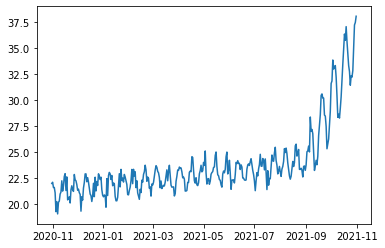

In [ ]:
i=2
ind=np.arange(N*i,N*(i+1))
plt.plot(df['ds'].iloc[ind],df['y'].iloc[ind])

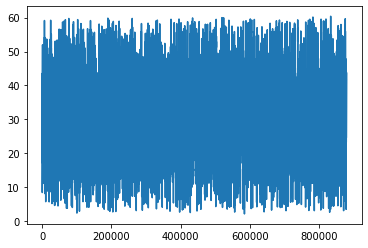

In [ ]:
df['y'].plot()

In [ ]:
df2=[]
n_max=20
for i,(mesh,df_tmp) in tqdm(enumerate(df.groupby('MESHCODE100')),total=n_max):
  if i>=n_max:break
  #df_tmp['y'].diff().plot()
  #break
  AD=Anomaly_Detection(train_days=60,valid_days=28,th=0.1,all_flag=True)
  date,score=AD.fit(df_tmp)
  df_tmp2=pd.DataFrame({'ds':date,'score':score,'MESHCODE100':mesh})
  df2.append(df_tmp2)
df2=pd.concat(df2)

100%|██████████| 20/20 [01:48<00:00,  5.41s/it]


In [ ]:
df2

,ds,score,MESHCODE100
0,2021-10-03,0.078558,1
1,2021-09-05,0.116670,1
2,2021-08-08,0.034937,1
3,2021-07-11,0.028381,1
4,2021-06-13,0.021932,1
...,...,...,...
5,2021-05-16,0.024654,20
6,2021-04-18,0.020430,20
7,2021-03-21,0.021834,20
8,2021-02-21,0.024610,20


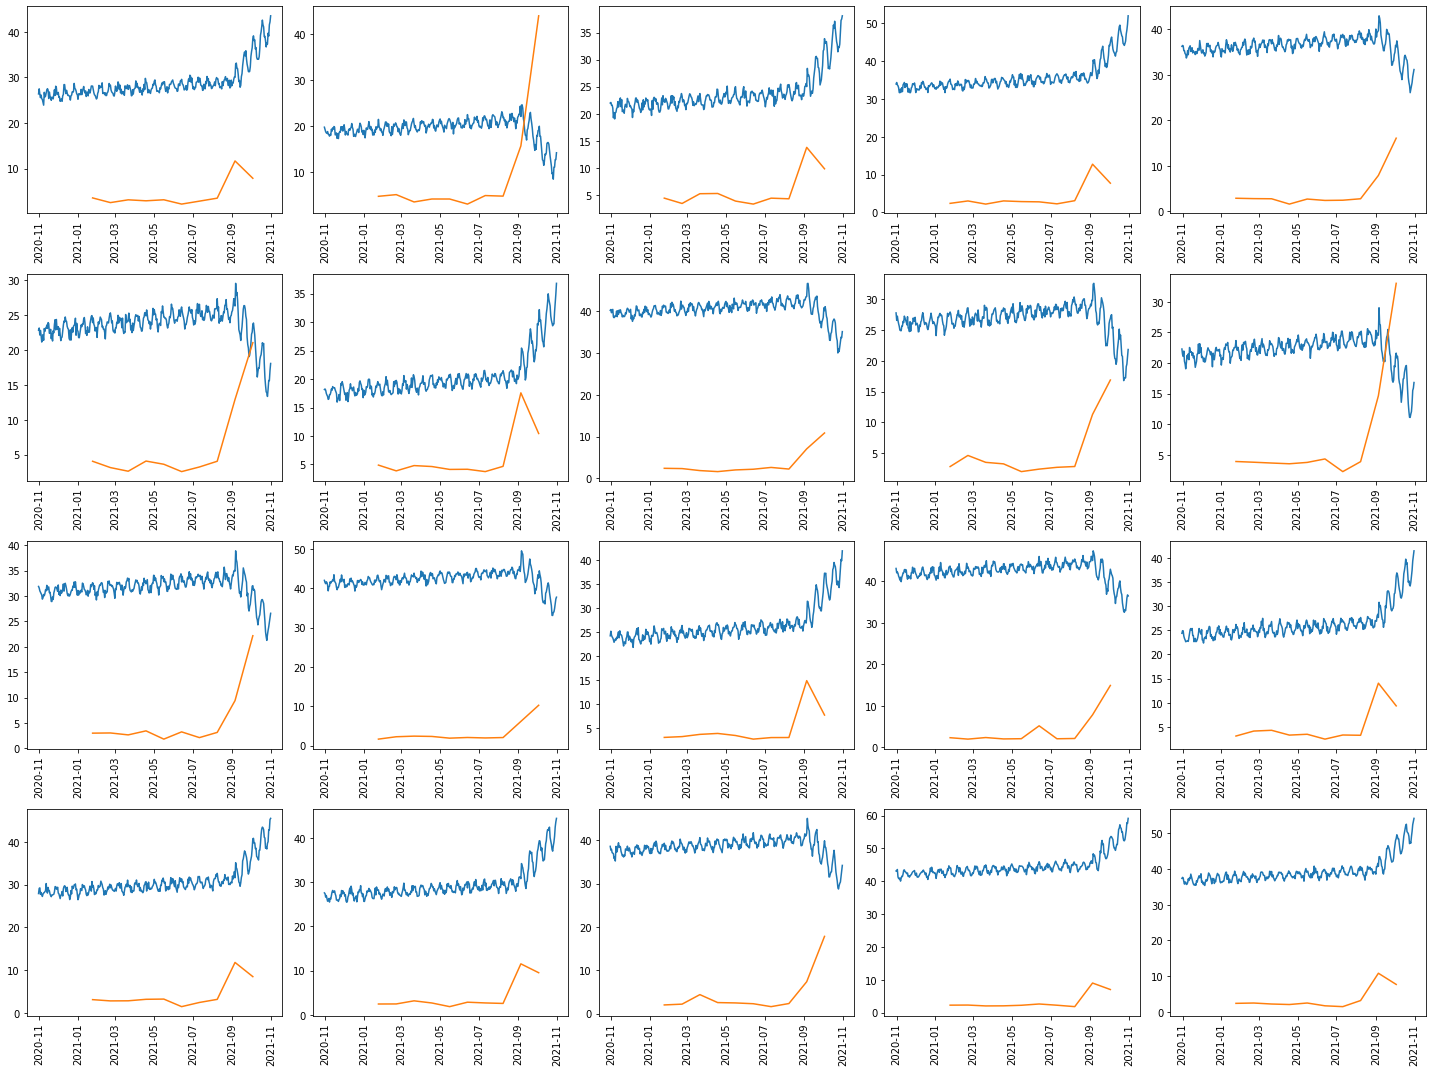

In [ ]:
fig = plt.figure(figsize=(20,15))
mesh_list=df2['MESHCODE100'].unique().tolist()
for i,mesh in enumerate(mesh_list):
  df_tmp=df[df['MESHCODE100']==mesh]
  df2_tmp=df2[df2['MESHCODE100']==mesh]

  ax = fig.add_subplot(4, 5, i+1)
  ax.plot(df_tmp['ds'],df_tmp['y'])
  ax.plot(df2_tmp['ds'],df2_tmp['score']*100)
  plt.xticks(rotation=90)

plt.tight_layout()
plt.show()